# Apply CNN Classifier to DESI Spectra and visualize results with gradCAM

Mini-SV2 tiles from February-March 2020:
- https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

See also the DESI tile picker with (limited) SV0 tiles from March 2020:
- https://desi.lbl.gov/svn/data/tiles/trunk/
- https://desi.lbl.gov/svn/data/tiles/trunk/SV0.html

In [2]:
import sys
sys.path.append('/global/homes/p/portmanm/timedomain/desitrip/py/')
sys.path.append('/global/homes/p/portmanm/desi/desispec/')

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras

from desitarget.cmx.cmx_targetmask import cmx_mask

from desitrip.preproc import rebin_flux, rescale_flux
from desitrip.deltamag import delta_mag

from astropy.io import fits
from astropy.table import Table, vstack, hstack

from glob import glob
from datetime import date

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

In [3]:
mpl.rc('font', size=14)

In [4]:
# Set up BGS target bit selection.
cmx_bgs_bits = '|'.join([_ for _ in cmx_mask.names() if 'BGS' in _])

## Select a Date & Tile from the Tile Picker

In [145]:
tile_ids = []
obsdates = []
petal_ids = []
rows = []

with open('temp.txt') as tfile:
    all_lines = tfile.readlines()
    
for line_idx in range(len(all_lines)):
    line = all_lines[line_idx].split(' ') # Get rid of spacing between
    tile_ids.append(line[0])
    obsdates.append(line[1])
    petal_ids.append(line[2])
    rows.append(line[-1].rstrip('\n'))

In [146]:
# Access redux folder.
zbfiles = []
cafiles = []
#print(rows)

redux='/global/project/projectdirs/desi/spectro/redux/daily/tiles'
for tile_id, obsdate, petal_id, row in zip(tile_ids[:], obsdates[:], petal_ids[:], rows[:]):
    prefix_in='/'.join([redux, '{}/{}'.format(tile_id, obsdate)])
    if not os.path.isdir(prefix_in):
        print('{} does not exist.'.format(prefix_in))
        tile_ids.remove(tile_id)
        obsdates.remove(obsdate)
        petal_ids.remove(petal_id)
        rows.remove(row)
        continue
        
    # List zbest and coadd files.
    # Data are stored by petal ID.
    fileend = '-'.join((petal_id, tile_id, obsdate))
    #print(fileend)
    zbfiles.extend(sorted(glob('{}/zbest-'.format(prefix_in) + fileend + '*.fits')))
    cafiles.extend(sorted(glob('{}/coadd-'.format(prefix_in) + fileend + '*.fits')))

/global/project/projectdirs/desi/spectro/redux/daily/tiles/513/20210504 does not exist.
/global/project/projectdirs/desi/spectro/redux/daily/tiles/289/20210505 does not exist.


In [147]:
# zbest files from redrock.
zbfiles
print(len(zbfiles))
print(len(cafiles))
print(len(tile_ids))
print(len(obsdates))
print(len(petal_ids))
print(len(rows))

21
21
22
22
22
22


In [80]:
# Co-added spectra from multiple exposures + the three spectrograph arms.
cafiles

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210221/coadd-3-80662-20210221.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/coadd-3-80662-20210322.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/228/20210405/coadd-5-228-20210405.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/217/20210406/coadd-3-217-20210406.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/28/20210407/coadd-6-28-20210407.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/246/20210408/coadd-8-246-20210408.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/219/20210409/coadd-3-219-20210409.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/228/20210410/coadd-2-228-20210410.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/221/20210412/coadd-4-221-20210412.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/283/20210413/co

## Load the Keras Model

Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.

In [148]:
tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
#tfmodel = '/global/homes/s/sybenzvi/desi/timedomain/desitrip/docs/nb/6label_cnn_restframe'
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

In [149]:
if classifier is not None:
    classifier.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 8)            32        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 16)            64    

## Loop Through Spectra and Classify

In [154]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None
handy_table = []

color_string = 'brz'
count = 0

for cafile, zbfile, row in zip(cafiles, zbfiles, rows[:-1]): # rows[:-1] IS TEMPORARY
    # Access data per petal.
    zbest = Table.read(zbfile, 'ZBEST')
    #print(zbest.colnames)
    #fibermap = Table.read(zbfile, 'FIBERMAP')
    targetid = zbest[int(row)]['TARGETID']
    chi2 = zbest[int(row)]['CHI2']
    if targetid == -146564:
        continue
    print(targetid)
    
    pspectra = read_spectra(cafile)
    cspectra = coadd_cameras(pspectra)
    fibermap = cspectra.fibermap
    ra = fibermap[int(row)]['TARGET_RA']
    dec = fibermap[int(row)]['TARGET_DEC']
    handy_table.append((targetid, ra, dec, tile_ids[count], obsdates[count], row))
    #print(pspectra.flux)S

    # Apply standard event selection.
    #isTGT = fibermap['OBJTYPE'] == 'TGT'
    #isGAL = zbest['SPECTYPE'] == 'GALAXY'
    
    #This is old selection, does not work anymore! BGS target is always 0
    #isBGS = fibermap['SV1_BGS_TARGET'] & bgs_mask.mask(sv1_bgs_bits) != 0
    #isBGS = bgs_mask.mask(bgs_bits) != 0
    #isGoodFiber = fibermap['FIBERSTATUS'] == 0
    #isGoodZbest = (zbest['DELTACHI2'] > 25.) & (zbest['ZWARN'] == 0)
    #select = isTGT & isGAL #& isBGS & isGoodFiber & isGoodZbest
    #fibermap = delta_mag(cspectra, fibermap, select, nsigma=3)
    #isBGS = fibermap['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    select = fibermap['TARGETID'] == targetid #isTGT & isGAL #& isBGS
    #exp_id = fibermap['EXPID'] & select # first need to figure out all columns as this fails
    #print(select)
    count += 1

    # Accumulate spectrum data.
    if allzbest is None:
        allzbest = zbest[select]
        allfmap = fibermap[select]
        allwave = cspectra.wave[color_string]
        allflux = cspectra.flux[color_string][select]
        allivar = cspectra.ivar[color_string][select]
        allmask = cspectra.mask[color_string][select]
        allres  = cspectra.resolution_data[color_string][select]
    else:
        allzbest = vstack([allzbest, zbest[select]])
        allfmap = vstack([allfmap, fibermap[select]])
        allflux = np.vstack([allflux, cspectra.flux[color_string][select]])
        allivar = np.vstack([allivar, cspectra.ivar[color_string][select]])
        allmask = np.vstack([allmask, cspectra.mask[color_string][select]])
        allres  = np.vstack([allres, cspectra.resolution_data[color_string][select]])

39627787731992967
INFO:spectra.py:253:read_spectra: iotime 0.318 sec to read coadd-3-80662-20210221.fits at 2021-05-21T12:57:31.706789


INFO:desiutil.log.dlm58.info:iotime 0.318 sec to read coadd-3-80662-20210221.fits at 2021-05-21T12:57:31.706789


39627787731992967
INFO:spectra.py:253:read_spectra: iotime 0.411 sec to read coadd-3-80662-20210322.fits at 2021-05-21T12:57:37.691381


INFO:desiutil.log.dlm58.info:iotime 0.411 sec to read coadd-3-80662-20210322.fits at 2021-05-21T12:57:37.691381


39627794392552723
INFO:spectra.py:253:read_spectra: iotime 0.513 sec to read coadd-5-228-20210405.fits at 2021-05-21T12:57:44.314714


INFO:desiutil.log.dlm58.info:iotime 0.513 sec to read coadd-5-228-20210405.fits at 2021-05-21T12:57:44.314714


39627782308760755
INFO:spectra.py:253:read_spectra: iotime 0.500 sec to read coadd-3-217-20210406.fits at 2021-05-21T12:57:51.696478


INFO:desiutil.log.dlm58.info:iotime 0.500 sec to read coadd-3-217-20210406.fits at 2021-05-21T12:57:51.696478


39627758233452823
INFO:spectra.py:253:read_spectra: iotime 0.510 sec to read coadd-8-246-20210408.fits at 2021-05-21T12:57:58.992906


INFO:desiutil.log.dlm58.info:iotime 0.510 sec to read coadd-8-246-20210408.fits at 2021-05-21T12:57:58.992906


39627770216583829
INFO:spectra.py:253:read_spectra: iotime 0.546 sec to read coadd-3-219-20210409.fits at 2021-05-21T12:58:06.067754


INFO:desiutil.log.dlm58.info:iotime 0.546 sec to read coadd-3-219-20210409.fits at 2021-05-21T12:58:06.067754


39627776273156346
INFO:spectra.py:253:read_spectra: iotime 0.465 sec to read coadd-2-228-20210410.fits at 2021-05-21T12:58:12.877762


INFO:desiutil.log.dlm58.info:iotime 0.465 sec to read coadd-2-228-20210410.fits at 2021-05-21T12:58:12.877762


39627788340170385
INFO:spectra.py:253:read_spectra: iotime 0.763 sec to read coadd-4-221-20210412.fits at 2021-05-21T12:58:20.365128


INFO:desiutil.log.dlm58.info:iotime 0.763 sec to read coadd-4-221-20210412.fits at 2021-05-21T12:58:20.365128


39627824641867969
INFO:spectra.py:253:read_spectra: iotime 0.506 sec to read coadd-9-283-20210413.fits at 2021-05-21T12:58:27.601516


INFO:desiutil.log.dlm58.info:iotime 0.506 sec to read coadd-9-283-20210413.fits at 2021-05-21T12:58:27.601516


39627830673281264
INFO:spectra.py:253:read_spectra: iotime 0.515 sec to read coadd-9-284-20210414.fits at 2021-05-21T12:58:34.788694


INFO:desiutil.log.dlm58.info:iotime 0.515 sec to read coadd-9-284-20210414.fits at 2021-05-21T12:58:34.788694


39627763564415912
INFO:spectra.py:253:read_spectra: iotime 0.526 sec to read coadd-1-43-20210415.fits at 2021-05-21T12:58:41.244987


INFO:desiutil.log.dlm58.info:iotime 0.526 sec to read coadd-1-43-20210415.fits at 2021-05-21T12:58:41.244987


39627872930892803
INFO:spectra.py:253:read_spectra: iotime 0.452 sec to read coadd-5-285-20210416.fits at 2021-05-21T12:58:47.824541


INFO:desiutil.log.dlm58.info:iotime 0.452 sec to read coadd-5-285-20210416.fits at 2021-05-21T12:58:47.824541


39627806467953230
INFO:spectra.py:253:read_spectra: iotime 0.489 sec to read coadd-5-229-20210417.fits at 2021-05-21T12:58:54.535215


INFO:desiutil.log.dlm58.info:iotime 0.489 sec to read coadd-5-229-20210417.fits at 2021-05-21T12:58:54.535215


39627812570665665
INFO:spectra.py:253:read_spectra: iotime 0.505 sec to read coadd-5-260-20210418.fits at 2021-05-21T12:59:01.168838


INFO:desiutil.log.dlm58.info:iotime 0.505 sec to read coadd-5-260-20210418.fits at 2021-05-21T12:59:01.168838


39627770317243639
INFO:spectra.py:253:read_spectra: iotime 0.452 sec to read coadd-8-252-20210419.fits at 2021-05-21T12:59:07.868422


INFO:desiutil.log.dlm58.info:iotime 0.452 sec to read coadd-8-252-20210419.fits at 2021-05-21T12:59:07.868422


39627758157956190
INFO:spectra.py:253:read_spectra: iotime 0.482 sec to read coadd-0-230-20210420.fits at 2021-05-21T12:59:14.708166


INFO:desiutil.log.dlm58.info:iotime 0.482 sec to read coadd-0-230-20210420.fits at 2021-05-21T12:59:14.708166


39627812570665665
INFO:spectra.py:253:read_spectra: iotime 0.468 sec to read coadd-5-260-20210429.fits at 2021-05-21T12:59:21.371741


INFO:desiutil.log.dlm58.info:iotime 0.468 sec to read coadd-5-260-20210429.fits at 2021-05-21T12:59:21.371741


39627842761262116
INFO:spectra.py:253:read_spectra: iotime 0.450 sec to read coadd-8-287-20210430.fits at 2021-05-21T12:59:28.175967


INFO:desiutil.log.dlm58.info:iotime 0.450 sec to read coadd-8-287-20210430.fits at 2021-05-21T12:59:28.175967


39627811916349621
INFO:spectra.py:253:read_spectra: iotime 0.489 sec to read coadd-6-47-20210501.fits at 2021-05-21T12:59:34.852809


INFO:desiutil.log.dlm58.info:iotime 0.489 sec to read coadd-6-47-20210501.fits at 2021-05-21T12:59:34.852809


39627770300469365
INFO:spectra.py:253:read_spectra: iotime 0.429 sec to read coadd-8-262-20210502.fits at 2021-05-21T12:59:41.020446


INFO:desiutil.log.dlm58.info:iotime 0.429 sec to read coadd-8-262-20210502.fits at 2021-05-21T12:59:41.020446


In [155]:
# Apply the DESITRIP preprocessing to selected spectra.
rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)
rsflux = rescale_flux(reflux)

In [156]:
# Run the classifier on the spectra.
# The output layer uses softmax activation to produce an array of label probabilities.
# The classification is based on argmax(pred).
pred = classifier.predict(rsflux)

In [157]:
pred.shape

(20, 9)

In [158]:
ymax = np.max(pred, axis=1)
print(ymax)
#handy_table.pop(0)

for i in range(len(handy_table)):
    print(handy_table[i], "-", ymax[i]) #print(handy_table)

[0.9808642  0.9869703  0.86546475 0.7859956  0.61458784 0.43221894
 0.6615132  0.33445066 0.6038762  0.52606064 0.8693157  0.5652247
 0.31849802 0.6508483  0.8216609  0.22200838 0.5915675  0.9812491
 0.5868254  0.99604464]
(39627787731992967, 179.0195194355948, 0.05786057275150698, '80662', '20210221', '348') - 0.9808642
(39627787731992967, 179.0195194355948, 0.05786057275150698, '80662', '20210322', '348') - 0.9869703
(39627794392552723, 216.22410150147854, 0.2088574536077048, '228', '20210405', '112') - 0.86546475
(39627782308760755, 215.8651632561341, -0.3120617652749298, '217', '20210406', '309') - 0.7859956
(39627758233452823, 220.7602253748339, -1.2144130785766516, '28', '20210407', '76') - 0.61458784
(39627770216583829, 215.17231460762667, -0.6370011726718479, '246', '20210408', '81') - 0.43221894
(39627776273156346, 216.10171857842838, -0.6213739467421516, '219', '20210409', '450') - 0.6615132
(39627788340170385, 215.3766888980232, -0.0017066518762649566, '228', '20210410', '15

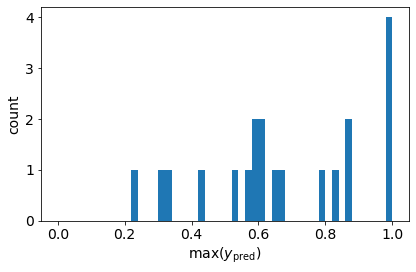

In [159]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
ax.hist(ymax, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count');
       #title='Tile {}, {}'.format(tile_id, obsdate));

### Selection on Classifier Output

To be conservative we can select only spectra where the classifier is very confident in its output, e.g., ymax > 0.99. See the [CNN training notebook](https://github.com/desihub/timedomain/blob/master/desitrip/docs/nb/cnn_multilabel-restframe.ipynb) for the motivation behind this cut.

In [160]:
idx = np.argwhere(ymax > 0.5) #0.99
labels = np.argmax(pred, axis=1)

In [161]:
idx.shape
label_names = ['Galaxy',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP',
          'KN']

In [162]:
# Randomly select 16 of the spectra and plot them.
#selection = sorted(np.random.choice(idx.flatten(), size=idx.shape[0], replace=False))
selection=idx
print(len(selection))

16


### GradCAM action happens here

Adapting from https://keras.io/examples/vision/grad_cam/

In [101]:
import tensorflow as tf
last_conv_layer_name = "conv1d_23"
classifier_layer_names = [
"batch_normalization_23",
"activation_23",
"max_pooling1d_23",
"flatten_5",
"dense_5",
"dropout_5",
"Output_Classes"
]

In [102]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        #print(layer_name,x.shape)
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    #print(grads.shape,pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    #We apply ReLU here and select only elements>0
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

### Apply GradCAM to one spectrum only


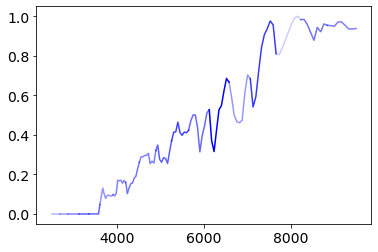

In [163]:
# Prepare image
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
#myarr=rsflux[:1,:] 
myarr=rsflux[selection[0],:] 

# Print what the top predicted class is
preds = classifier.predict(myarr)
#print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    myarr, classifier, last_conv_layer_name, classifier_layer_names
)


color='blue'
rewave_nbin_inblock=rewave.shape[0]/float(heatmap.shape[0])
first_bin=0
for i in range(1,heatmap.shape[0]+1):
    alpha=np.min([1,heatmap[i-1]+0.2])
    last_bin=int(i*rewave_nbin_inblock)
    plt.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha)
    first_bin=last_bin


### Apply GradCAM to all spectra classified as transients


In [128]:
#allzbest = allzbest[1:] #TEMP
#allzbest.pprint_all()
#print(labels.shape)
#print(labels)
#print(rewave.shape)
#print(rsflux.shape)

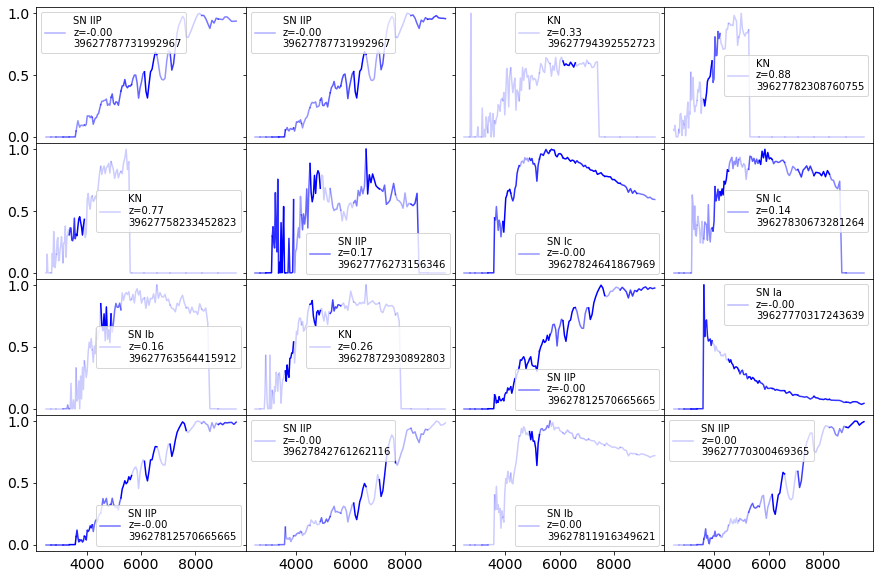

In [164]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    myarr=rsflux[j,:] 
    #print()

    # Print what the top predicted class is
    preds = classifier.predict(myarr)
    #print("Predicted:", preds)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        myarr, classifier, last_conv_layer_name, classifier_layer_names
    )

    color='blue'
    rewave_nbin_inblock=rewave.shape[0]/float(heatmap.shape[0])
    first_bin=0
    for i in range(1,heatmap.shape[0]+1):
        alpha=np.min([1,heatmap[i-1]+0.2])
        last_bin=int(i*rewave_nbin_inblock)
        if (i==1):
            ax.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha,\
                    label=label_names[labels[j[0]]]+'\nz={:.2f}'.format(allzbest[j[0]]['Z']) + "\n" + str(allzbest[j[0]]['TARGETID']))
        else:
            ax.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha)
        first_bin=last_bin
    ax.legend(fontsize=10)

### Plot spectra of objects classified as transients
Plot observed spectra

In [133]:
testwave, testflux, testivar = rebin_flux(allwave, allflux, allivar,
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)

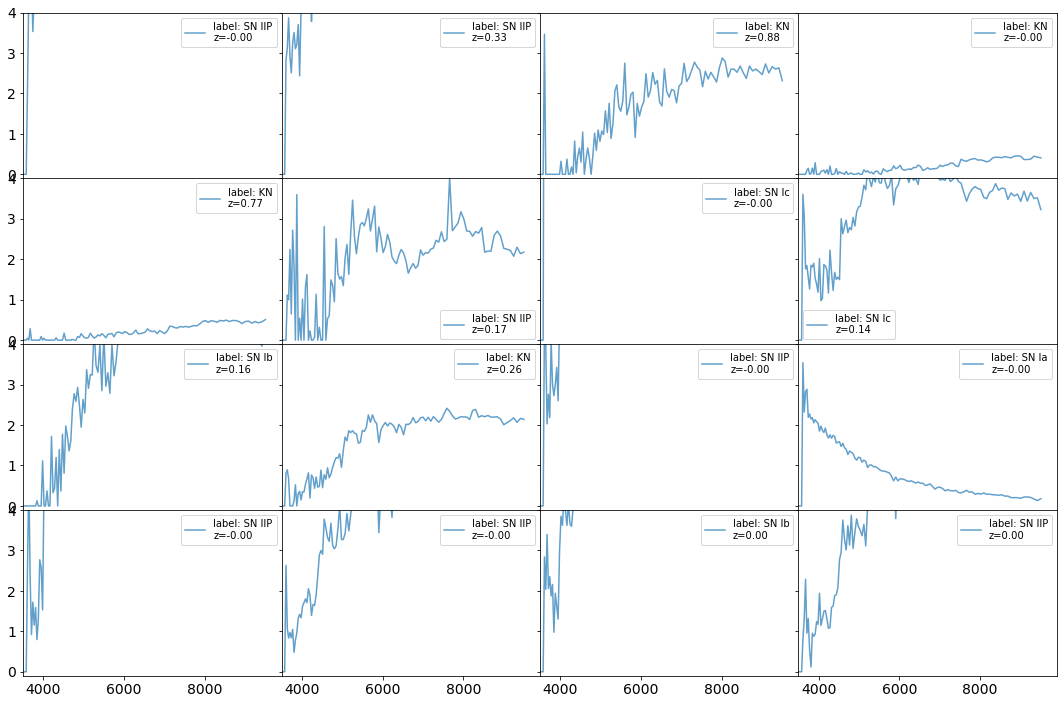

In [143]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(testwave, testflux[j[0]], alpha=0.7, label='label: '+label_names[labels[j[0]]] +# Just this for single plot with [0] on testflux, label_names, allzbest
            '\nz={:.2f}'.format(allzbest[j[0]]['Z'])) # +
            #'\nobsdate={}'.format(obsdates[j[0]]) +
            #'\ntile id: {}'.format(tile_ids[j[0]]) +
            #'\npetal id: {}'.format(petal_ids[j[0]]))
    
    ax.set(xlim=(3500,9900),ylim=(-0.1,4))
    #ax.fill_between([5600,6000],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    #ax.fill_between([7400,7800],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    ax.legend(fontsize=10)
    
#for k in [0,1,2]:
#    axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#    axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]', xlim=(3500,9900))
    
fig.tight_layout();
#filename = "spectra_plots/all_spectra_TAMU_ylim"
#plt.savefig(filename)

### For plotting individual plots

In [140]:

for j in selection:
    plt.plot(testwave, testflux[j[0]], alpha=0.7, label='label: '+ label_names[labels[j[0]]] + # Just this for single plot with [0] on testflux, label_names, allzbest
            '\nz={:.2f}'.format(allzbest[j[0]]['Z'])) # +
            #'\nobsdate={}'.format(obsdates[j[0]]) +
            #'\ntile id: {}'.format(tile_ids[j[0]]) +
            #'\npetal id: {}'.format(petal_ids[j[0]]))
    
    plt.xlim(3500, 9900)
    #plt.ylim(-0.1, 50)
    #ax.fill_between([5600,6000],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    #ax.fill_between([7400,7800],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    plt.legend(fontsize=10)
    #filename = "spectra_plots/"+"_".join(("TAMU", "spectra", str(obsdates[j[0]]), str(tile_ids[j[0]]), str(petal_ids[j[0]]), label_names[labels[j[0]]].replace(" ", "-")))
    filename = "spectra_plots/"+"_".join(("TAMU", "spectra", str(obsdates[j[0]+1]), str(tile_ids[j[0]+1]), str(petal_ids[j[0]+1]), label_names[labels[j[0]]].replace(" ", "-"))) # temp
    #plt.show();
    plt.savefig(filename)
    plt.clf()
    
#for k in [0,1,2]:
#    axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#    axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]', xlim=(3500,9900))
    
#fig.tight_layout();
#filename = "spectra_plots/all_spectra_TAMU_ylim"
#filename = "_".join(("spectra", str(obsdate), str(tile_id), label_names[labels[0]].replace(" ", "-")))
#plt.savefig(filename)

<Figure size 432x288 with 0 Axes>